# Visualizing the Pix2Pix results

Let's visualize some random results from the Pix2Pix model. To do so we just need to load a generator model and feed it with a "source image". Here you will need to provide an image that is compatible with the source you trained on. We will test two of the pre-trained models we provide you with. One transforming face landmarks into Rembrandt paintings, and one transforming face edges into comics drawings. First let's see how to do this in a notebook: 

In [1]:
import os 
import numpy as np
import tensorflow as tf

import cv2
from skimage import io
from skimage import feature

import matplotlib
import matplotlib.pyplot as plt

## Utils

In [18]:
def transform_image(img):
    img = (img - 127.5) / 127.5             # super weird error, doesn't work with training=False, even if it should 😤 
    result = generator(np.expand_dims(img, 0), training=True)[0].numpy()
    return result * 0.5 + 0.5    

def apply_bw_cv2(img, thresh1=160, thresh2=250):
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.merge([grey_img, grey_img, grey_img]) # Force three channels for shape compat, thanks ChatGPT!

def apply_canny_cv2(img, thresh1=160, thresh2=250, invert=False):
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grey_img, thresh1, thresh2)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def apply_canny_skimage(img, sigma=1.5, invert=False):
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)   

---

## Landmarks to Rembrant

First let's load the generator. You need to watch out for two variables here:
- `model_path`
- `epoch`

The first variable, `model_path` defines the directory where you saved your models.

The second, `epoch` defines the epoch for which you want to load a model. You can examine the directory and the example images for each epoch, to choose which epoch you want to visualize.

To test this you can download [a pre-trained model for the 100th epoch](https://enist.org/dmlap_models/landmarks2rembrandt.zip).

Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.


In [14]:
model_path = './models/edges2rembrandt'
epoch = 100

generator = tf.keras.models.load_model(
    os.path.join(model_path, f'e{epoch}_generator.hd5')
)

Now let's load a face image (Spock) find the face landmarks, draw them and then apply the model. We will first define a function that uses the [Canvas API](https://github.com/colormotor/py5canvas) to create the face landmarks and draw them into an image

Then we will load an image (make sure it is 256x256 pixels in size) and use the generator model we loaded to apply the model to the face landmarks

In [ ]:
img = io.imread('images/spock256.jpg')
landmark_img = apply_canny_skimage(img) # try apply_canny_cv2 & possible to play with channels

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed input')
plt.imshow(landmark_img)
plt.axis('off')
plt.subplot(1, 3, 3)
gen_img = transform_image(landmark_img)
plt.title('Generated image')
plt.imshow(gen_img)
plt.axis('off')
plt.show()

---

## Edges to comics

Now let's try a similar procedure with the Edge to comics. Again, to test this you can download [a pre-trained model for the 100th epoch here](https://enist.org/dmlap_models/edges2comics.zip). Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.

In [24]:
model_path = './models/edges2comics'
epoch = 100

generator = tf.keras.models.load_model(
    os.path.join(model_path, f'e{epoch}_generator.hd5')
)

And again apply a similar procecss to transform our input

In [ ]:
img = io.imread('images/spock256.jpg')
edges_img = apply_canny_skimage(img)  # try apply_canny_cv2 & possible to play with channels

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed input')
plt.imshow(edges_img)
plt.axis('off')
print(np.max(landmark_img))
plt.subplot(1, 3, 3)
gen_img = transform_image(edges_img)
plt.title('Generated image')
plt.imshow(gen_img)
plt.axis('off')
plt.show()

---

## Facades 

Let's try now with the "facade" dataset (one of the official pix2pix datasets).
To test this you can download [a pre-trained model for the 64th epoch here](https://enist.org/dmlap_models/facades.zip).

Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.

Let's load the model for a given epoch as usual:

In [26]:
model_path = './models/facades'
epoch = 64

generator = tf.keras.models.load_model(
    os.path.join(model_path, f'e{epoch}_generator.hd5')
)

The color map for the facades is based on the ["jet" color map](https://matplotlib.org/stable/tutorials/colors/colormaps.html), which maps continuous values between 0 and 1 to a color palette. See [this document](https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_2013.pdf) for details on what each color means. Matplotlib gives us easy access to these colors

In [12]:
def jet_color(v):
    c = matplotlib.colormaps.get_cmap('jet')
    return np.array(c(v)) * 255 # The output of this function is between 0 and 1, we will use 0 to 255 colors

Here we will use the Canvas API directly to generate some random rectangles filled with colors from the palette. The labels are (should be) organized as follows:  

0. background
1. facade
2. window
3. door
4. cornice
5. sill
6. balcony
7. blind
8. deco
9. molding
10. pillar
11. shop

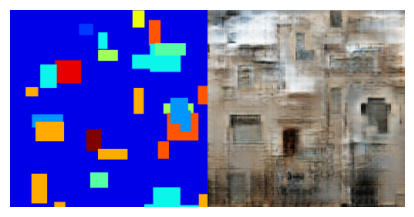

In [28]:
import canvas

# this gives us values between 0 and 1 for the labels
labels = np.linspace(0, 1, 12)

def random_label():   
    #return labels[np.random.choice([2, 3, 6, 8, 10])] # place here the labels you want to randomly choose from
    return np.random.choice(labels[2:]) # simply excludes background and facade
    #return np.random.uniform(0.1, 1.0)
c = canvas.Canvas(512, 256)
c.background(jet_color(0)[:-1]) # Fill with the darkest color (background)
c.no_stroke()

# Draw the main facade
pad = 0
c.fill(jet_color(labels[1]))
c.rect(pad, pad, 256-pad*2, 256)

# Draw some random rectangle with random feature colors
for i in range(30):
    c.fill(jet_color(random_label()))
    c.rect(np.random.uniform(pad, c.height-pad*2, size=2), np.random.uniform(2, 7, size=2)*6)
    #c.fill(jet_color(random_label()))
    #c.circle(np.random.uniform(pad, c.height-pad, size=2), np.random.uniform(5, c.height*0.15)*0.5) #, size=2))
# Get the left half of the canvas image
img = c.get_image()[:, :256]
# And transform it using our pix2pix model
result = transform_image(img)
c.image(result, [256, 0])
c.show()